# **1. Imports**

In [4]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import os
import tensorflow as tf
from matplotlib import pyplot as plt
%matplotlib inline
from PIL import Image
import glob as glob
import sys

2023-04-29 18:37:46.369691: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# **2. Environment Setup**

In [5]:
# Path to the Environment Directory
ENV_PATH = '/Users/henriqueoliveira18/Documents/Developer/traffic-sign-detection'

# Go to the Environment Directory
os.chdir(ENV_PATH)
print(os.getcwd())

/Users/henriqueoliveira18/Documents/Developer/traffic-sign-detection


In [6]:
# Clone TensorFlow Model Garden
if not os.path.exists('models'):
    !git clone https://github.com/tensorflow/models.git
else:
    print('Models already cloned')

# Clone Darkflow
if not os.path.exists('darkflow'):
    !git clone https://github.com/thtrieu/darkflow.git
else:
    print('Darkflow already cloned')

Models already cloned
Darkflow already cloned


In [5]:
!apt-get install protobuf-compiler python-pil python-lxml python-tk
!cd '/Users/henriqueoliveira18/Documents/Developer/traffic-sign-detection/models/research' && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install . 

zsh:1: command not found: apt-get
Processing /Users/henriqueoliveira18/Documents/Developer/traffic-sign-detection/models/research
  Preparing metadata (setup.py) ... done
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1655312 sha256=247c6a691881d195e7e67be73ba6253b04586c59a8649452ba8fcc76032ae1a6
  Stored in directory: /private/var/folders/kf/pzvj7rys6mj1w84psfmpw3l00000gn/T/pip-ephem-wheel-cache-0z47dacf/wheels/a2/59/dd/8f9c45ae6b46329b51c9667c6e6c7dccbdc9afd36d137a7c2a
Successfully built object-detection
  Attempting uninstall: object-detection
    Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1

[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [6]:
%cd '/Users/henriqueoliveira18/Documents/Developer/traffic-sign-detection/models/research/object_detection/builders'
!python model_builder_tf2_test.py

/Users/henriqueoliveira18/Documents/Developer/traffic-sign-detection/models/research/object_detection/builders
/Users/henriqueoliveira18/Documents/Developer/test/TFODCourse/tfod/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
Running tests under Python 3.10.9: /Users/henriqueoliveira18/Documents/Developer/test/TFODCourse/tfod/bin/python
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_deepmac
W0429 17:59:48.801683 140704590918464 batch_normalization.py:1426] `tf.keras.layers.experimental.SyncBatchNormalization` endpoint is deprec

In [12]:

%cd '/Users/henriqueoliveira18/Documents/Developer/traffic-sign-detection/models/research/object_detection'
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

/Users/henriqueoliveira18/Documents/Developer/traffic-sign-detection/models/research/object_detection


# **3. TensorFlow Object Detection API**

## 3.1 Selecting the model

In [7]:
model_dict = {
    1: 'faster_rcnn_inception_resnet_v2_atrous',
    2: 'faster_rcnn_resnet_101',
    3: 'faster_rcnn_resnet50',
    4: 'faster_rcnn_inception_v2',
    5: 'rfcn_resnet101',
    6: 'ssd_inception_v2',
    7: 'ssd_mobilenet_v1'
}

model_num = int(input("Enter a model number (1-7): "))

if model_num in model_dict:
    MODEL_NAME = model_dict[model_num]
    print("Selected model:", MODEL_NAME)
else:
    print("Invalid model number.")


Selected model: faster_rcnn_inception_resnet_v2_atrous


## 3.2 Paths

In [8]:
MODEL_PATH = os.path.join(ENV_PATH, 'models', MODEL_NAME)
CKPT_PATH = os.path.join(MODEL_PATH, 'inference_graph/frozen_inference_graph.pb')
LABEL_PATH = os.path.join(ENV_PATH, 'scripts', 'gtsdb3_label_map.pbtxt')
NUM_CLASSES = 3

## 3.3 Load a frozen Tensorflow model

In [13]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.compat.v1.GraphDef()
    with tf.compat.v1.gfile.GFile(CKPT_PATH, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

## 3.4 Loading Label Map

In [14]:
label_map = label_map_util.load_labelmap(LABEL_PATH)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)
print(label_map)

item {
  name: "prohibitory"
  id: 1
}
item {
  name: "mandatory"
  id: 2
}
item {
  name: "danger"
  id: 3
}



## 3.5 Helper code

In [15]:
# This function gets a input as an image and returns it as a NumPy array.
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

## 3.6 Loading Images

In [21]:
# Path to folder with images
TEST_IMAGES_DIR_PATH = os.path.join(ENV_PATH, 'test_images')
TEST_IMAGES_PATHS = glob.glob(os.path.join(TEST_IMAGES_DIR_PATH, '*.JPG'))

# Size of the output images
IMAGE_SIZE = (20, 20)

## 3.7 Detections

In [20]:
# This code outputs all the tensors in the graph.
with detection_graph.as_default():
    with tf.compat.v1.Session(graph=detection_graph) as sess:
        for op in detection_graph.get_operations():
            print(op.name)

Const
Const_1
Const_2
image_tensor
ToFloat
Preprocessor/map/Shape
Preprocessor/map/strided_slice/stack
Preprocessor/map/strided_slice/stack_1
Preprocessor/map/strided_slice/stack_2
Preprocessor/map/strided_slice
Preprocessor/map/TensorArray
Preprocessor/map/TensorArrayUnstack/Shape
Preprocessor/map/TensorArrayUnstack/strided_slice/stack
Preprocessor/map/TensorArrayUnstack/strided_slice/stack_1
Preprocessor/map/TensorArrayUnstack/strided_slice/stack_2
Preprocessor/map/TensorArrayUnstack/strided_slice
Preprocessor/map/TensorArrayUnstack/range/start
Preprocessor/map/TensorArrayUnstack/range/delta
Preprocessor/map/TensorArrayUnstack/range
Preprocessor/map/TensorArrayUnstack/TensorArrayScatter/TensorArrayScatterV3
Preprocessor/map/Const
Preprocessor/map/TensorArray_1
Preprocessor/map/while/Enter
Preprocessor/map/while/Enter_1
Preprocessor/map/while/Merge
Preprocessor/map/while/Merge_1
Preprocessor/map/while/Less/Enter
Preprocessor/map/while/Less
Preprocessor/map/while/LoopCond
Preprocessor/

Processing image /Users/henriqueoliveira18/Documents/Developer/traffic-sign-detection/test_images/IMG_5627.JPG...


2023-04-30 22:04:27.912630: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "CropAndResize" attr { key: "T" value { type: DT_FLOAT } } attr { key: "extrapolation_value" value { f: 0 } } attr { key: "method" value { s: "bilinear" } } inputs { dtype: DT_FLOAT shape { dim { size: -678 } dim { size: -679 } dim { size: -680 } dim { size: 1088 } } } inputs { dtype: DT_FLOAT shape { dim { size: -104 } dim { size: 4 } } } inputs { dtype: DT_INT32 shape { dim { size: -104 } } } inputs { dtype: DT_INT32 shape { dim { size: 2 } } value { dtype: DT_INT32 tensor_shape { dim { size: 2 } } int_val: 17 } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2600 num_cores: 12 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 12582912 memory_size: 268435456 } outputs { dtype: DT_FLOAT s

Detected 2 objects: mandatory, mandatory


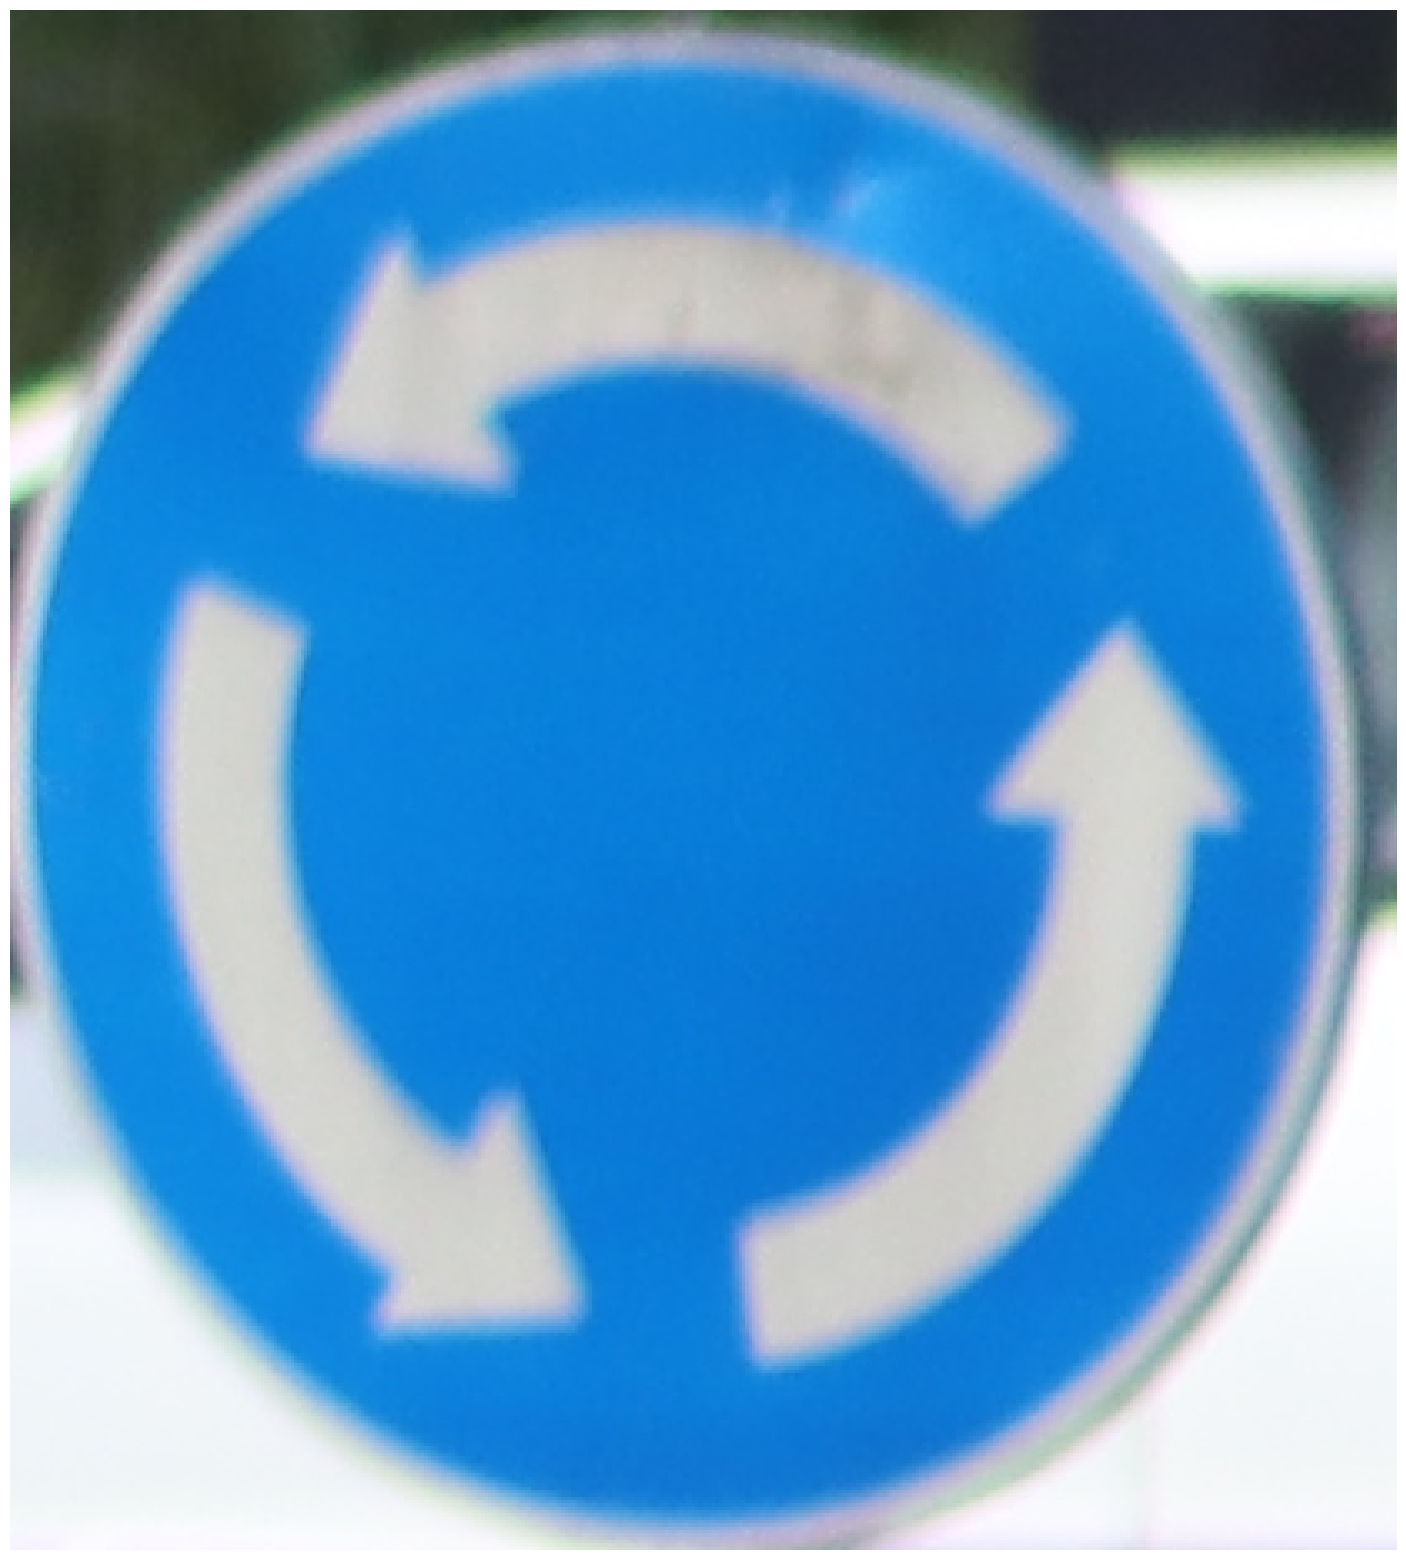

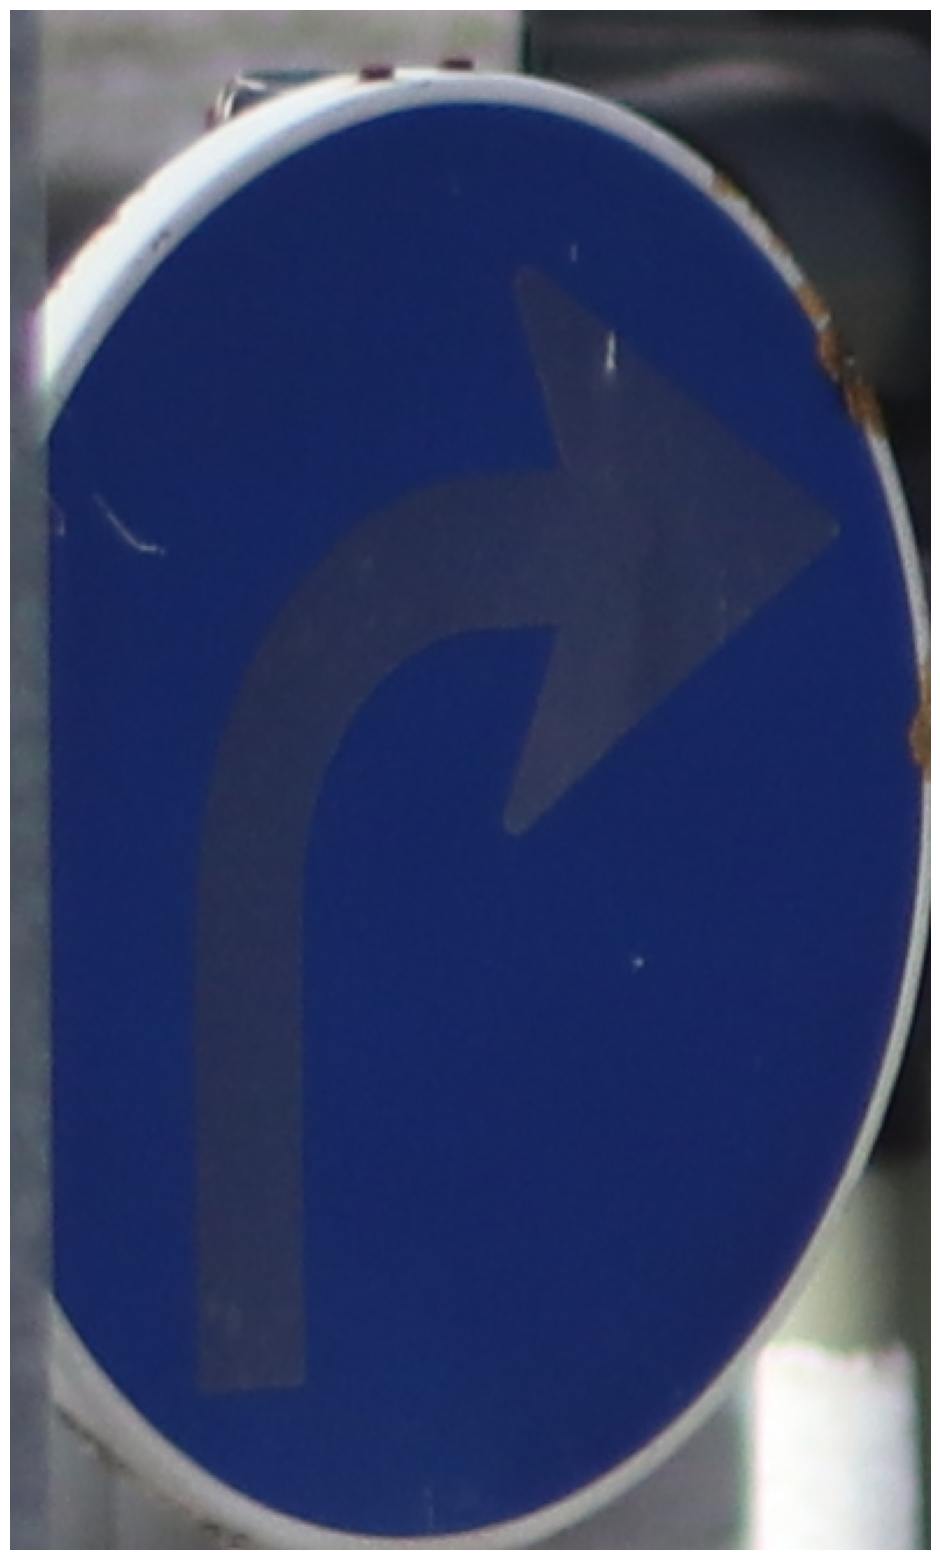

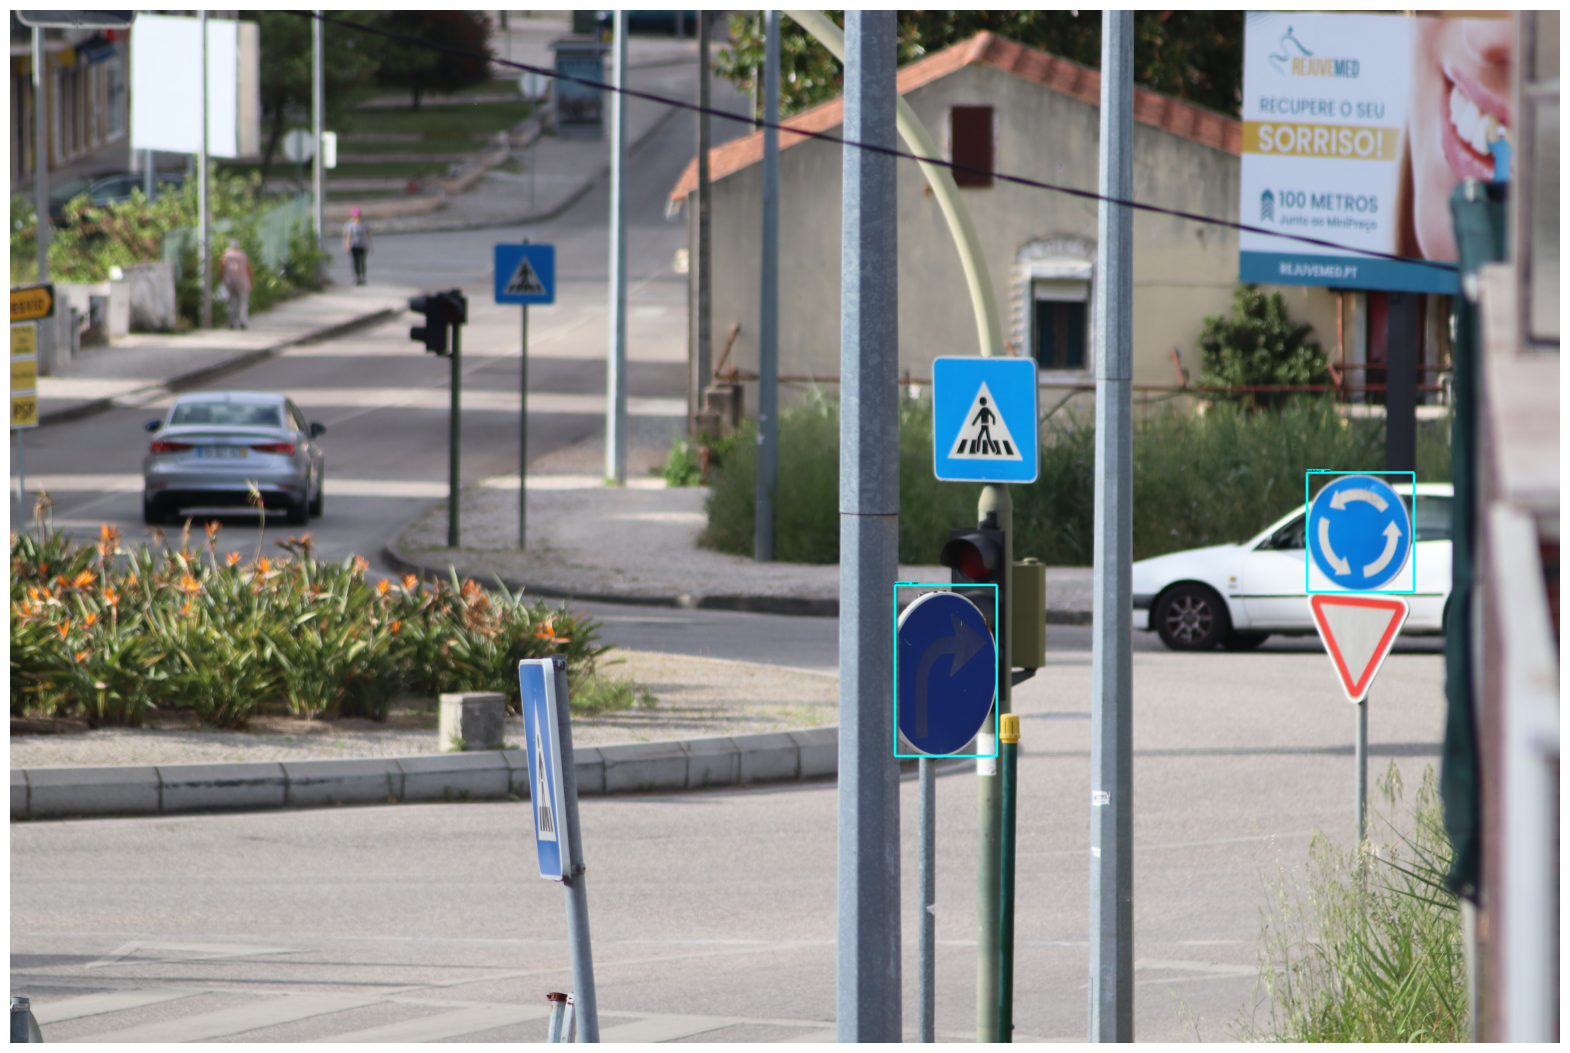

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

with detection_graph.as_default():
    with tf.compat.v1.Session(graph=detection_graph) as sess:
        for idx, image_path in enumerate(TEST_IMAGES_PATHS):
            image = Image.open(image_path)
            print("Processing image {}...".format(image_path))
            # the array based representation of the image will be used later in order to prepare the
            # result image with boxes and labels on it.
            image_np = load_image_into_numpy_array(image)
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            # Each box represents a part of the image where a particular object was detected.
            boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            # Each score represent how level of confidence for each of the objects.
            # Score is shown on the result image, together with the class label.
            scores = detection_graph.get_tensor_by_name('detection_scores:0')
            classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')
            # Actual detection.
            (boxes, scores, classes, num_detections) = sess.run(
                [boxes, scores, classes, num_detections],
                feed_dict={image_tensor: image_np_expanded})
            if np.squeeze(scores)[0] > 0.5:  # adjust the threshold as needed
                # print the number and class of objects detected
                num_objects = len(np.where(np.squeeze(scores) > 0.5)[0])
                object_classes = [category_index[c]['name'] for c in np.squeeze(classes)[:num_objects]]
                print("Detected {} objects: {}".format(num_objects, ', '.join(object_classes)))
                for i in range(num_objects):
                    # create a new figure for each object detected
                    plt.figure(idx*num_objects + i, figsize=IMAGE_SIZE)
                    plt.axis('off')
                    # crop and plot the image for the current object detected
                    ymin, xmin, ymax, xmax = tuple(boxes[0][i].tolist())
                    im_width, im_height = image.size
                    (left, right, top, bottom) = (xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height)
                    cropped_image = image.crop((left, top, right, bottom))
                    plt.imshow(cropped_image)
                    plt.show()
            # Visualization of the results of a detection.
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                line_thickness=10)
            # plot the original image
            plt.figure(idx*num_objects + num_objects, figsize=IMAGE_SIZE)
            plt.axis('off')
            plt.imshow(image_np)
            plt.show()

